In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import tensorflow as tf


from aidapy import load_data
from aidapy.ml.lstm.preprocess import preprocess_data
#from aidapy.ml.lstm.utils import numpy_to_dataloader, run_model, extract_continuous_intervals, reformat_dtw_res
#from aidapy.ml.lstm.model import LSTMnn
#from aidapy.ml.lstm.visualize import plot_set_of_storms
#from aidapy.ml.lstm.dtw import dtw_measure

%matplotlib notebook

np.random.seed(1234)

# Load data

In [2]:
start_time = datetime(2001, 1, 14, 0, 0, 0)
end_time = datetime(2016, 1, 1, 0, 0, 0) # 2016
settings = {'prod': ['all']}

output = 'DST'
omni_data = load_data(mission='omni', start_time=start_time, end_time=end_time, **settings)

# Transform initial data

Features used by Brecht: Solar wind speed, density, Bz, |B|.
I would also use as input data from [t-1, t-2, t-4, t-8]. This would give a total input of 16 neurons.
Splitting should be done randomly, but shuffling the data in a per month base.

In [98]:
features = ['F', 'BZ_GSM', 'N', 'V']

features = ['ABS_B', 
            'F',
            'N',
            'T',
            'Mach_num',
            'BZ_GSM',
            'Ratio',
            'V',
            'Beta',
            'E',
            'IMF',
            ]

# REMOVE ABS_B
features = ['F',
            'N',
            'T',
            'BZ_GSM',
            'V',
            'E',
            'IMF',
            ]

df = pd.DataFrame(omni_data['all1'].values,
                  index = omni_data['all1'].coords['time1'].values,
                  columns = omni_data['all1'].coords['products'].values)

# Input: t, t-1, t-2, t-3, t-4
df_input = df[features].copy()
df_input, scaler_input = preprocess_data(df_input)
df_input_minus_one = df_input.shift(1)
df_input_minus_one.columns = [str(col) + '_1' for col in df_input_minus_one.columns]
df_input_minus_two = df_input.shift(2)
df_input_minus_two.columns = [str(col) + '_2' for col in df_input_minus_two.columns]
df_input_minus_four = df_input.shift(4)
df_input_minus_four.columns = [str(col) + '_4' for col in df_input_minus_four.columns]
df_input_minus_eight = df_input.shift(8)
df_input_minus_eight.columns = [str(col) + '_8' for col in df_input_minus_eight.columns]

#df_input_final = pd.concat([df_input, df_input_minus_one, df_input_minus_two,
#                            df_input_minus_four], axis=1)

df_input_final = pd.concat([df_input, df_input_minus_one, df_input_minus_two], axis=1)
df_input_final = pd.concat([df_input], axis=1)
#df_input_final = pd.concat([df_input], axis=1)

# Output
# Two hours in advance
df_dst = df[['DST']].copy()
df_dst, scaler_output = preprocess_data(df_dst)

df_ouput = df_dst.shift(-2)
#df_ouput, scaler_output = preprocess_data(df_ouput)

#df_final = pd.concat([df_input_final, df_dst, df_ouput], axis=1)
df_final = pd.concat([df_input_final, df_ouput], axis=1)

df_final = df_final.dropna()

#df['Delta_Dst'] = df['DST'].diff()

#df_input_final = df_final.drop('DST', axis=1)
#df_input_final

In [99]:
df.columns

Index(['Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS', 'ABS_B', 'F', 'THETA_AV',
       'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM',
       'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By', 'SIGMA$Bz', 'T', 'N',
       'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure', 'SIGMA$T', 'SIGMA$N',
       'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V', 'SIGMA$ratio', 'E', 'Beta',
       'Mach_num', 'Mgs_mach_num', 'PR$FLX_1', 'PR$FLX_2', 'PR$FLX_4',
       'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX', 'R', 'F10_INDEX', 'KP',
       'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX', 'PC_N_INDEX',
       'Solar_Lyman_alpha', 'Proton_QI'],
      dtype='object')

In [100]:
# Group all data by month
# GB=train.groupby([(train.index.year),(train.index.month)]).sum()
# GB.index
split = [g.to_numpy() for n,g in df_final.groupby(pd.Grouper(freq='M')) if g.shape[0] != 0]
#split = {month_index:g for month_index, (n,g) in enumerate(df_final.groupby(pd.Grouper(freq='M'))) if g.shape[0] != 0}

nb_month = len(split)
month_array = np.arange(nb_month)

In [101]:
batch_size_sim = [len(x) for x in split]

In [102]:
# Generate month index for test, validation and training
test_ratio = 0.25
validation_ratio = 0.2

test_size = int(test_ratio * nb_month)
test_remaining = nb_month - test_size
validation_size = int(validation_ratio * test_remaining)

test_month_index = np.random.choice(month_array, size=test_size, replace=False)
remaining_month_index = np.array(list(filter(lambda x: x not in test_month_index, month_array)))
validation_month_index = np.random.choice(remaining_month_index, size=validation_size, replace=False)
training_month_index = np.array(list(filter(lambda x: x not in validation_month_index, remaining_month_index)))

In [103]:
test_split = [split[x] for x in test_month_index]
validation_split = [split[x] for x in validation_month_index]
training_split = [split[x] for x in training_month_index]

test_split = np.concatenate(test_split, axis=0)
validation_split = np.concatenate(validation_split, axis=0)
training_split = np.concatenate(training_split, axis=0)

In [104]:
x_test = test_split[:, :-1]
x_val = validation_split[:, :-1]
x_train = training_split[:, :-1]

y_test = test_split[:, -1]
y_val = validation_split[:, -1]
y_train = training_split[:, -1]

# MLP model

## Define model

In [105]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.RMSprop(0.001)

batch_size = 128
nb_epochs = 50
verbose = 2
output_directory = 'models_reduced'
file_path_best = os.path.join(output_directory, 'best_model.hdf5')
file_path_last = os.path.join(output_directory, 'last_model.hdf5')

nb_features = x_train.shape[1]

model = keras.models.Sequential()
# First layer
model.add(keras.layers.Dense(64, input_dim=nb_features, activation='relu'))
#model.add(keras.layers.Dropout(0.1))
#model.add(keras.layers.Activation('relu'))

# Second layer
model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.Dropout(0.1))
#model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Dense(64, activation='relu'))

#model.add(keras.layers.Activation('linear'))
model.add(keras.layers.Dense(1))

model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0000001)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path_best, monitor='val_loss', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, mode='min')

callbacks = [reduce_lr,model_checkpoint, early_stopping]

In [106]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________


## Train model

In [107]:
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs, verbose=verbose,
                 validation_data=(x_val,y_val), callbacks=callbacks)

model.save(file_path_last)

Epoch 1/50
593/593 - 3s - loss: 0.4420 - mae: 0.4513 - mse: 0.4420 - val_loss: 0.4755 - val_mae: 0.4470 - val_mse: 0.4755 - lr: 0.0010
Epoch 2/50
593/593 - 2s - loss: 0.4222 - mae: 0.4434 - mse: 0.4222 - val_loss: 0.4563 - val_mae: 0.4483 - val_mse: 0.4563 - lr: 0.0010
Epoch 3/50
593/593 - 2s - loss: 0.4146 - mae: 0.4404 - mse: 0.4146 - val_loss: 0.4532 - val_mae: 0.4481 - val_mse: 0.4532 - lr: 0.0010
Epoch 4/50
593/593 - 2s - loss: 0.4108 - mae: 0.4393 - mse: 0.4108 - val_loss: 0.4528 - val_mae: 0.4451 - val_mse: 0.4528 - lr: 0.0010
Epoch 5/50
593/593 - 2s - loss: 0.4078 - mae: 0.4383 - mse: 0.4078 - val_loss: 0.4661 - val_mae: 0.4447 - val_mse: 0.4661 - lr: 0.0010
Epoch 6/50
593/593 - 5s - loss: 0.4029 - mae: 0.4365 - mse: 0.4029 - val_loss: 0.4601 - val_mae: 0.4482 - val_mse: 0.4601 - lr: 0.0010
Epoch 7/50
593/593 - 8s - loss: 0.4025 - mae: 0.4365 - mse: 0.4025 - val_loss: 0.4632 - val_mae: 0.4432 - val_mse: 0.4632 - lr: 0.0010
Epoch 8/50
593/593 - 8s - loss: 0.3991 - mae: 0.4356 - 

## Make prediction

In [108]:
x_test.shape

(32554, 7)

In [109]:
feature_names=list(df_final.columns)[:-1]
feature_names

['F', 'N', 'T', 'BZ_GSM', 'V', 'E', 'IMF']

In [110]:
shap_values[0][0,:]

array([ 0.00617146, -0.02320703,  0.01035853,  0.023637  ,  0.07980022,
        0.00360994, -0.00560474, -0.56281536])

In [111]:
import shap

model = keras.models.load_model(file_path_best)
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:10000,:])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_train[:100,:])

# init the JS visualization code
shap.initjs()

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
#shap.force_plot(explainer.expected_value, shap_values[0][:2,:], x_test[:2,:])#, matplotlib=True)
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][:5,:], x_test[:5,:],
                feature_names=feature_names, link='logit')#, link="logit")

You have provided over 5k background samples! For better performance consider using smaller random sample.


In [81]:
shap.initjs()
shap.summary_plot(shap_values)#, features = feature_names, plot_type='bar')

In [27]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
names_list = ['x{}'.format(i) for i in range(25)]
bounds = [[-2.0, 2.0] for i in range(25)]

problem = {
    'num_vars': 25,
    'names': names_list,
    'bounds': bounds
}

# Generate samples
param_values = saltelli.sample(problem, 10000)

# Run model (example)
model = keras.models.load_model(file_path_best)
Y = np.ravel(model.predict(param_values))

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

# Print the first-order sensitivity indices
print(Si['S1'])

Parameter S1 S1_conf ST ST_conf
x0 0.012652 0.003843 0.018739 0.000622
x1 0.008244 0.002538 0.010863 0.000439
x2 -0.000802 0.001640 0.005214 0.000267
x3 0.000078 0.001340 0.003284 0.000156
x4 0.043914 0.005808 0.050700 0.001807
x5 0.011677 0.003847 0.016512 0.000667
x6 -0.001337 0.001622 0.003765 0.000177
x7 -0.000548 0.001838 0.003726 0.000178
x8 -0.000246 0.001989 0.004881 0.000212
x9 0.000504 0.001682 0.003740 0.000173
x10 0.002244 0.001794 0.004412 0.000226
x11 -0.001211 0.001426 0.002671 0.000134
x12 0.004914 0.002112 0.004670 0.000228
x13 -0.000946 0.001600 0.003646 0.000173
x14 0.001386 0.001563 0.003994 0.000181
x15 0.001399 0.002030 0.004997 0.000234
x16 0.001185 0.001380 0.002588 0.000118
x17 -0.000460 0.001824 0.004018 0.000232
x18 -0.001127 0.001727 0.003689 0.000169
x19 0.000017 0.001973 0.004579 0.000244
x20 0.008078 0.002951 0.011154 0.000512
x21 0.000989 0.001569 0.003783 0.000198
x22 0.001388 0.002148 0.006070 0.000296
x23 0.003146 0.002223 0.004780 0.000244
x24 0.8764

In [30]:
model = keras.models.load_model(file_path_best)

y_pred = model.predict(x_test)

y_pred = scaler_output.inverse_transform(y_pred)
y_test = scaler_output.inverse_transform(y_test)


from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.9077554682736402

<IPython.core.display.Javascript object>


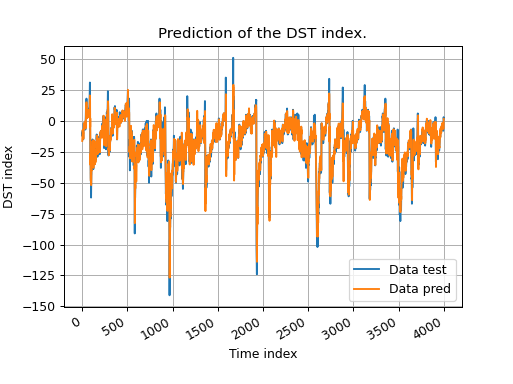

In [31]:
plt.figure()
plt.title('Prediction of the DST index.')
plt.plot(y_test[21000:25000], label='Data test')
plt.plot(y_pred[21000:25000], label='Data pred')
plt.xlabel('Time index')
plt.ylabel('DST index')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [139]:
x_test.shape

(27195, 45)

In [140]:
from eli5.permutation_importance import get_score_importances
def score(X, y):
    y_pred_ = model.predict(X)
    #final_score = 1.0 - np.square(np.ravel(y_pred), y).mean()
    final_score = r2_score(y, y_pred_)
    #print(final_score)
    return final_score

base_score, score_decreases = get_score_importances(score,x_test, y_test)
feature_importances = np.mean(score_decreases, axis=0)

In [147]:
feature_importances

()

In [153]:
score_decreases[-4]

array([ 2.88878130e-03, -3.46635464e-03,  1.10009449e-03, -3.06104731e-04,
        7.55493823e-04,  6.85158143e-03,  5.38023904e-04,  2.23371485e-03,
        6.67297702e-04,  8.31930154e-03,  4.94740486e-04,  6.97948505e-04,
       -2.13936467e-04, -1.48881882e-04,  1.63341495e-04, -1.03720165e-03,
       -1.74307380e-04,  2.21214888e-04, -2.17527433e-03, -4.45537566e-04,
       -3.10283590e-03, -1.66153062e-05, -5.24645886e-04,  6.89881817e-04,
       -1.61138189e-03, -4.24240743e-04,  1.15971875e-03,  2.11842997e-03,
       -6.92019335e-05,  1.50979945e-03, -1.25384834e-03, -4.67954919e-03,
        9.53818331e-04,  7.44375632e-04,  1.01552737e-03, -3.15031591e-04,
       -1.60738775e-03,  3.30937494e-05, -3.09809383e-05,  6.65761432e-04,
       -6.12011584e-04,  2.31079405e-04, -1.13842000e-04,  2.91482641e-04,
        7.47843309e-02])

In [142]:
print(df_input_final.columns)

toto = {key: value for (key, value) in zip(df_input_final, feature_importances)}

Index(['ABS_B', 'F', 'N', 'T', 'Mach_num', 'BZ_GSM', 'Ratio', 'V', 'Beta', 'E',
       'IMF', 'ABS_B_1', 'F_1', 'N_1', 'T_1', 'Mach_num_1', 'BZ_GSM_1',
       'Ratio_1', 'V_1', 'Beta_1', 'E_1', 'IMF_1', 'ABS_B_2', 'F_2', 'N_2',
       'T_2', 'Mach_num_2', 'BZ_GSM_2', 'Ratio_2', 'V_2', 'Beta_2', 'E_2',
       'IMF_2', 'ABS_B_4', 'F_4', 'N_4', 'T_4', 'Mach_num_4', 'BZ_GSM_4',
       'Ratio_4', 'V_4', 'Beta_4', 'E_4', 'IMF_4'],
      dtype='object')


In [143]:
toto

{'ABS_B': 0.00291222879748525,
 'F': -0.0034825837040097342,
 'N': 0.0010909963051487282,
 'T': -0.000253696030233197,
 'Mach_num': 0.0006841752097898723,
 'BZ_GSM': 0.0068726297790033366,
 'Ratio': 0.0005131337706868244,
 'V': 0.0021944792966233084,
 'Beta': 0.0006563020857263347,
 'E': 0.008227046821879025,
 'IMF': 0.0005093053989337903,
 'ABS_B_1': 0.0006954001663932897,
 'F_1': -0.00021981480015638156,
 'N_1': -0.00011032774968433579,
 'T_1': 0.00018524423857062543,
 'Mach_num_1': -0.0010422667877062696,
 'BZ_GSM_1': -0.00017054139807517465,
 'Ratio_1': 0.00020406186243757674,
 'V_1': -0.0021959297038742333,
 'Beta_1': -0.0004382602797551982,
 'E_1': -0.003099255724987504,
 'IMF_1': -0.00012064898061776574,
 'ABS_B_2': -0.0004886825025662844,
 'F_2': 0.0006606618012503951,
 'N_2': -0.0015773080381629168,
 'T_2': -0.00040147620727042365,
 'Mach_num_2': 0.0011957735260329726,
 'BZ_GSM_2': 0.002055531487611617,
 'Ratio_2': -8.182380885668472e-05,
 'V_2': 0.001489506305055377,
 'Beta_2

<IPython.core.display.Javascript object>


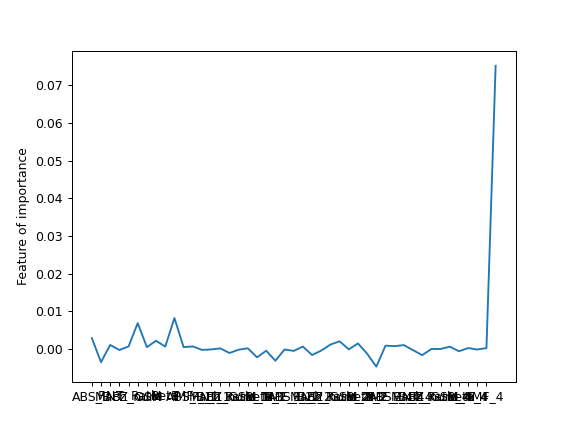

In [144]:
features = df_input_final.columns

plt.figure()
plt.plot(feature_importances)
plt.ylabel('Feature of importance')
plt.xticks(np.arange(len(features)), features)
plt.show()



In [ ]:
# Old scikit-learn - quite bad
#layer_size = (64, 64)
#batch_size = 200
#lr = 0.001
#max_iter = 500

#regr = MLPRegressor(hidden_layer_sizes=layer_size, batch_size=batch_size, learning_rate_init=lr,
#                    max_iter = max_iter, shufffle=True, random_state=1234, verbose=True).fit(X_train, y_train)

# Plot storm

In [33]:
def get_storm_dates(stormname='storms_1981_2016.csv'):
    return pd.read_csv(stormname, index_col=0, dtype={'date1': str, 'date2': str},
                       parse_dates=['date1', 'date2'])

def get_storms(data, storm_dates):
    '''Check which storms lie in the given dataset
    Input:
        data: dataset with dates
        storm_dates: list of known storm occurences
    Output:
        measured features during the storm
        storm-dates that lie in data
    '''
    rs = []
    valid_storms = []
    for (_, dates) in storm_dates.iterrows():
        ss = data.loc[dates[0]:dates[1]]
        if ss.shape[0] != 0:
            rs.append(ss)
            valid_storms.append((dates[0].strftime('%Y-%m-%d'), dates[1].strftime('%Y-%m-%d')))
    print('Number of storms in dataset: {}'.format(len(valid_storms)))
    return pd.concat(rs), np.array(valid_storms)

In [34]:
storm_dates = get_storm_dates()
test_storms, test_storm_dates = get_storms(test, storm_dates)
test_storm_dates = test_storm_dates.astype('datetime64')

Number of storms in dataset: 17


In [35]:
time_forward = train_out.shape[2]
time_back = train_in.shape[1]
num_epochs = 30
hidden_size = 50
momentum = 0.8
num_layers = 1
learning_rate = 0.0003
batch_size = 64
num_feat = train_in.shape[2]

IndexError: tuple index out of range

In [18]:
train = numpy_to_dataloader(train_in, train_out, batch_size)
valid = numpy_to_dataloader(valid_in, valid_out, 1024)

In [19]:
model = LSTMnn(num_feat, num_layers, hidden_size, time_forward)
predict = run_model(model, test_in, file_path='model/model')

<IPython.core.display.Javascript object>


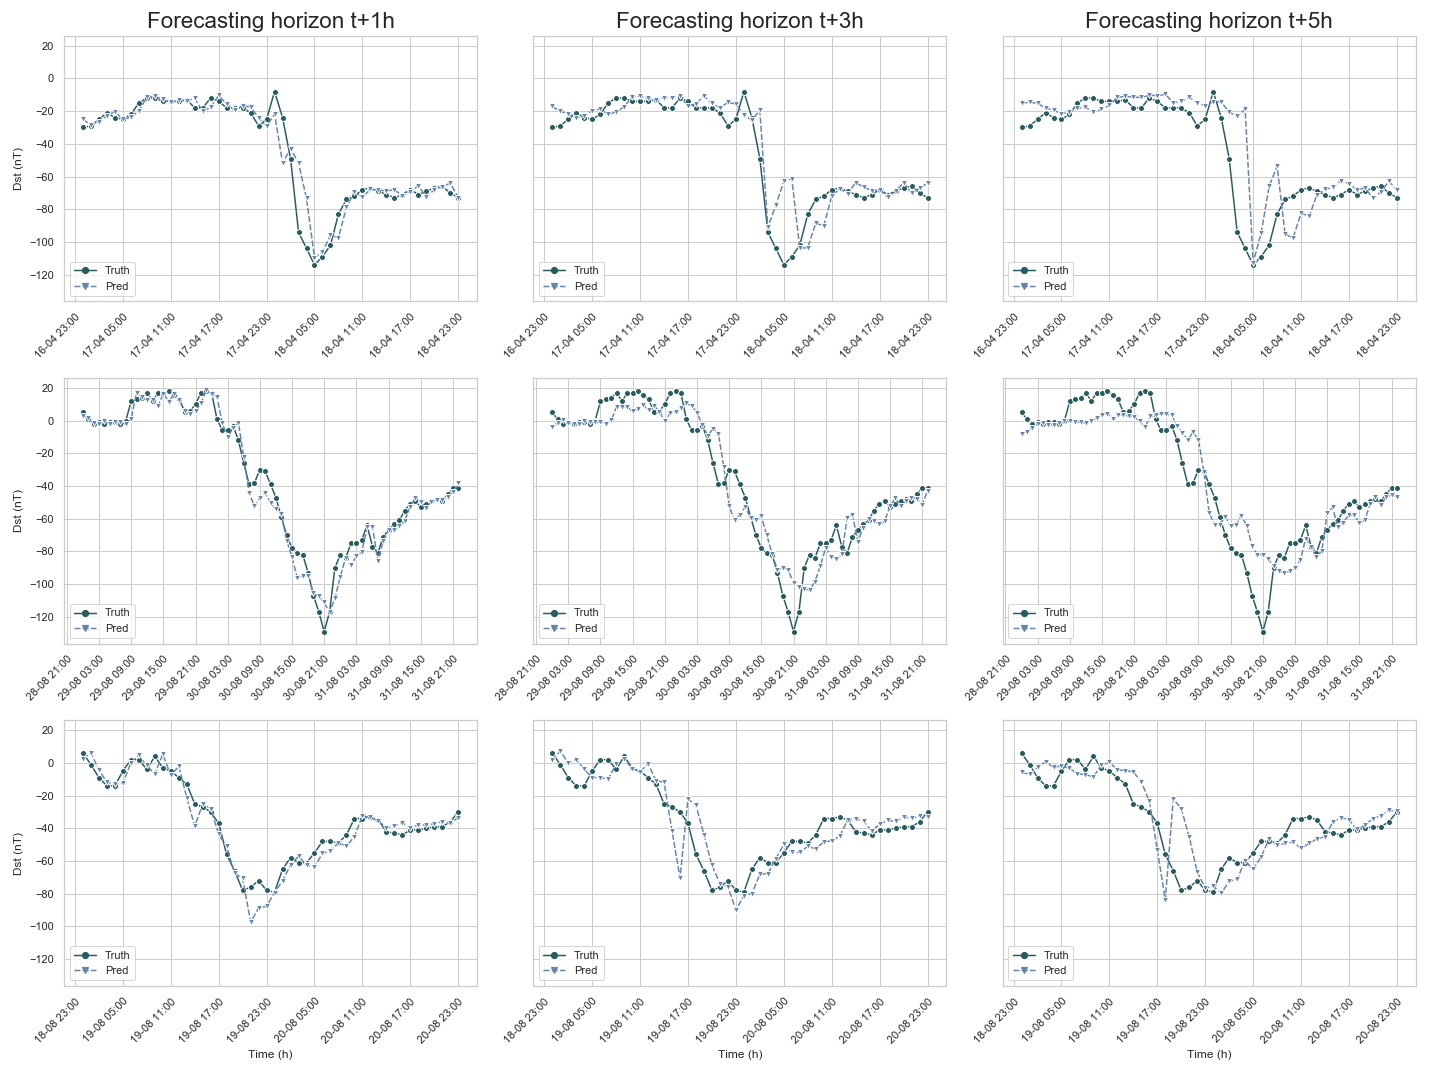

In [20]:
times = [0, 2, 4]
selected_storms = [test_storm_dates[0], test_storm_dates[7], test_storm_dates[13]]
plot_set_of_storms(test_out[:, 0], predict[:, 0], lookup, selected_storms, times, save=False)